In [1]:
# Basic imports and setup
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import the new data loader and plotting functions
from analyze_modules import load_parameter_matrix, plot_2d_matrix

# from petrobuffer.buffers import calcBuffer
# from petrobuffer.conversions import get_relative_fo2

# get viridis colormap
cmap = plt.get_cmap('viridis')
cmap.set_bad(color='black')
plt.rcParams['figure.dpi'] = 200

In [2]:
# Define parameters for the matrix
folder = '../output/EqCond+Remove/'
P0s = np.array([1e6, 1e7, 1e8])
Tints = np.array([50, 75, 100, 125, 150, 200, 250])
CplusOs = np.array([1e-3, 3.16e-3, 1e-2, 3.16e-2, 1e-1])
CtoOs = np.array([0.1, 0.59, 1.0])

In [3]:
def interpolate_BOA(i_press):

    i_temp = -1
    BOAmatrix = np.empty((len(CplusOs), len(CtoOs)))
    BOAmatrix[:] = np.nan
    while np.isnan(BOAmatrix).any() or np.nanmin(BOAmatrix) < T_freeze:
        try:
            i_temp += 1
            BOAmatrix = get_BOA_TOA(i_temp, i_press)[0]
            if not np.isnan(BOAmatrix).any() and np.nanmin(BOAmatrix) < T_freeze:
                # Don't do for last iteration!
                BOAmatrix_old = np.copy(BOAmatrix)
                i_temp_old = i_temp
        except FileNotFoundError:
            continue

    Tint_1 = Tints[i_temp_old]
    Tint_2 = Tints[i_temp]
    Tsurf_1 = BOAmatrix_old.flatten()[np.nanargmin(BOAmatrix)]
    Tsurf_2 = np.nanmin(BOAmatrix)
    Tint_f = (Tint_2 - Tint_1) * (T_freeze - Tsurf_1) / (Tsurf_2 - Tsurf_1) + Tint_1
    print('Interpolating BOA for T =', Tint_f, 'K, Tint(1,2) =', Tint_1, Tint_2, 'K, Tsurf(1,2) =', Tsurf_1, Tsurf_2)

    BOAmatrix_interp = np.empty((len(CplusOs), len(CtoOs)))
    BOAmatrix_interp[:] = np.nan

    BOAmatrix_interp = BOAmatrix_old.copy()
    BOAmatrix_interp += (Tint_f - Tint_1) * (BOAmatrix - BOAmatrix_old) / (Tint_2 - Tint_1)

    # test
    test = np.isclose(np.nanmin(BOAmatrix_interp), T_freeze, atol=1e-2)
    if test:
        print('Interpolation successful')
    else:
        print('Interpolation failed')

    return BOAmatrix_interp, Tint_f


def set_white(ax):
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    ax.tick_params(axis='x', colors='white', which='both')  # Set color for both major and minor ticks
    ax.tick_params(axis='y', colors='white', which='both')  # Set color for both major and minor ticks

    try: # if colorbar is present
        ax.images[0].colorbar.ax.yaxis.label.set_color('white')
        ax.images[0].colorbar.ax.tick_params(axis='y', colors='white', which='both')
        ax.images[0].colorbar.outline.set_color('white')
        
        ax.images[0].colorbar.ax.xaxis.label.set_color('white')
        ax.images[0].colorbar.ax.tick_params(axis='x', colors='white', which='both')
        ax.images[0].colorbar.outline.set_color('white')
    except:
        pass

def increase_size(ax, linewidth=3, fontsize=14):
    for l in ax.lines:
        l.set_linewidth(linewidth)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(linewidth)
    ax.xaxis.set_tick_params(width=linewidth)
    ax.yaxis.set_tick_params(width=linewidth)
    fontsize = 14
    ax.xaxis.label.set_size(fontsize)
    ax.yaxis.label.set_size(fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    

In [4]:
# --- Example 1: Load BOA Temperature Matrix ---
i_temp = 2
i_press = 2
fixed_params = {
    'P0': P0s[i_press],
    'Tint': Tints[i_temp],
    'planet': 'Earth'
}

# The new function directly returns the 2D data matrix
BOA_matrix = load_parameter_matrix(
    folder,
    fixed_params=fixed_params,
    param1_name='CtoO',
    param1_values=CtoOs,
    param2_name='CplusO',
    param2_values=CplusOs,
    what_to_extract='T_BOA' # Use the convenient key for Bottom-of-Atmosphere Temp
)

TOA_matrix = load_parameter_matrix(
    folder,
    fixed_params=fixed_params,
    param1_name='CtoO',
    param1_values=CtoOs,
    param2_name='CplusO',
    param2_values=CplusOs,
    what_to_extract='T_TOA' # Use the convenient key for Top-of-Atmosphere Temp
)

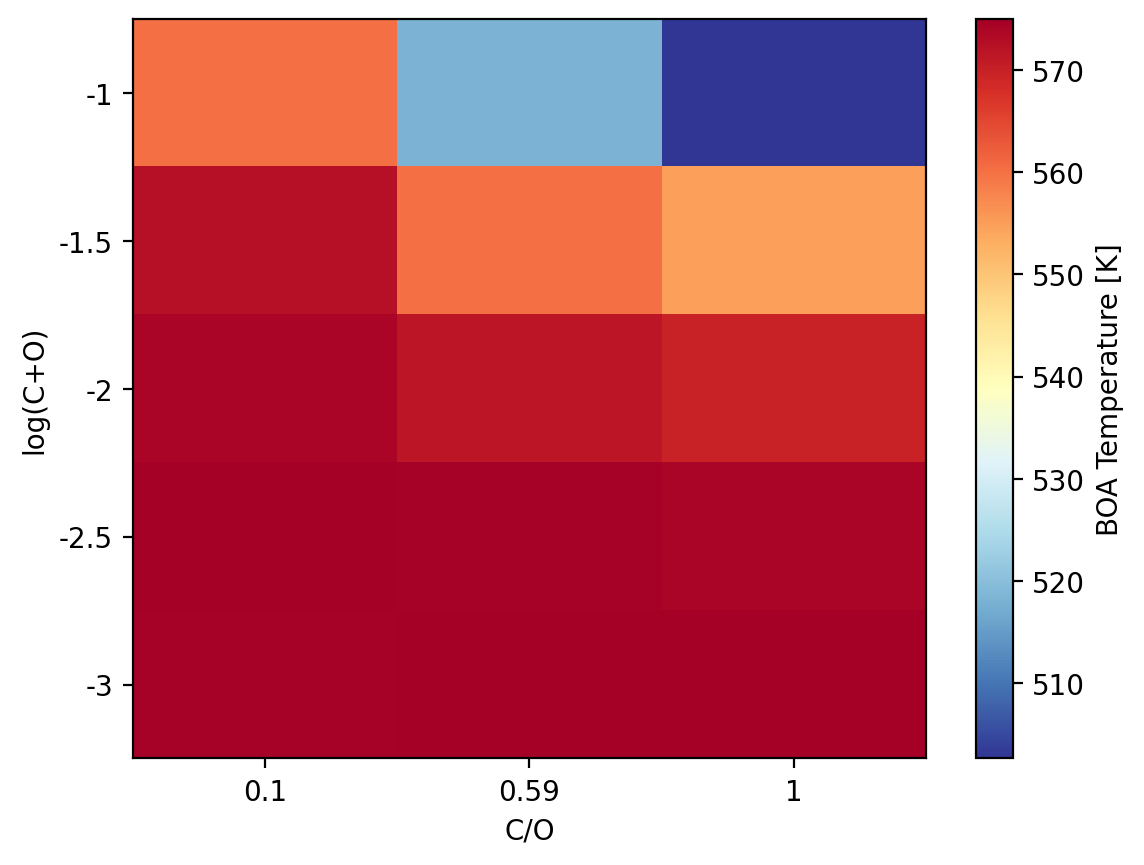

In [5]:
# Plot the matrix using the new utility
fig, ax = plot_2d_matrix(
    BOA_matrix,
    CtoOs,
    CplusOs,
    param1_name='C/O',
    param2_name='log(C+O)',
    z_label='BOA Temperature [K]',
    cmap='RdYlBu_r',
    log_z=False#, # Log scale for colorbar
    #vmin=273,
    #vmax=400
)
# The old plot_other had a CpO_log parameter, which is now handled by formatting the tick labels.
ax.set_yticklabels([f'{np.log10(v):.2g}' for v in CplusOs])
plt.show()

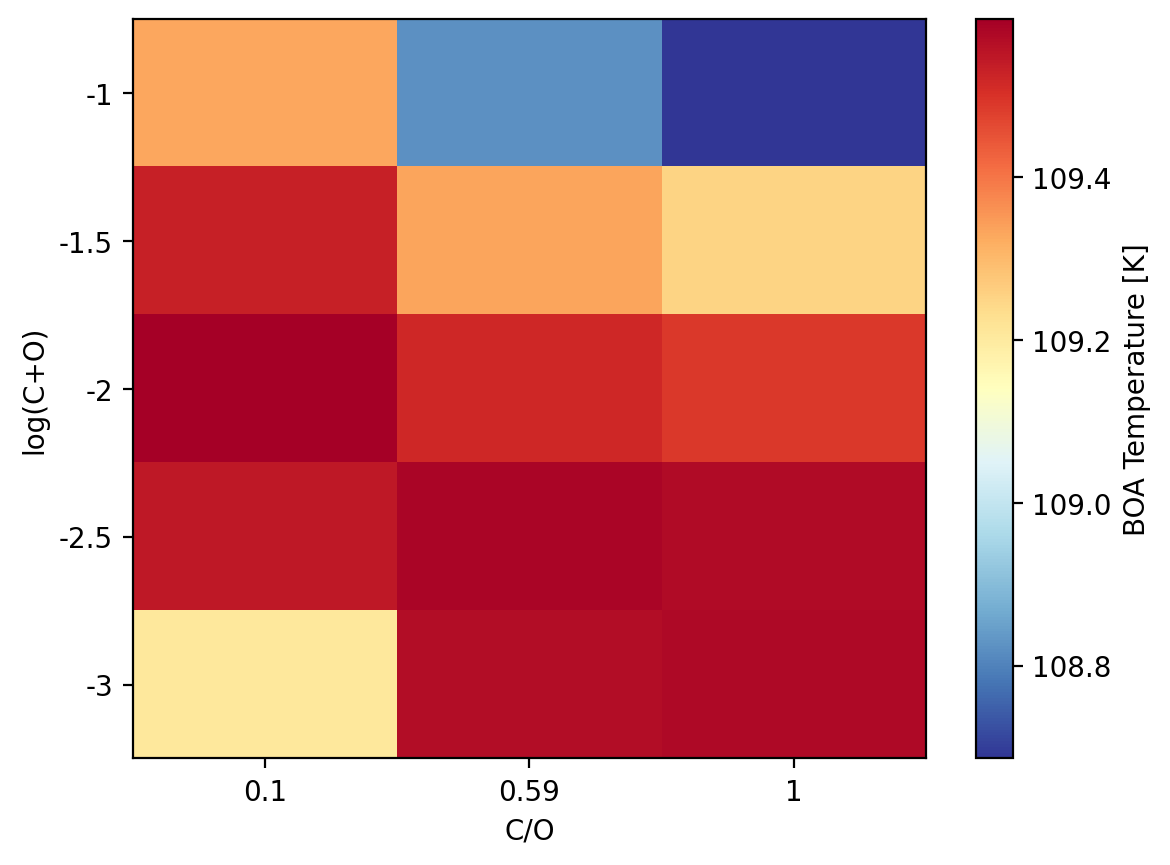

In [6]:
# Plot the matrix using the new utility
fig, ax = plot_2d_matrix(
    TOA_matrix,
    CtoOs,
    CplusOs,
    param1_name='C/O',
    param2_name='log(C+O)',
    z_label='BOA Temperature [K]',
    cmap='RdYlBu_r',
    log_z=False#, # Log scale for colorbar
    #vmin=273,
    #vmax=400
)
# The old plot_other had a CpO_log parameter, which is now handled by formatting the tick labels.
ax.set_yticklabels([f'{np.log10(v):.2g}' for v in CplusOs])
plt.show()

In [7]:
# --- Example 2: Load a matrix of 1D profiles (e.g., H2O abundance) ---
data_matrix = load_parameter_matrix(
    folder,
    fixed_params=fixed_params,
    param1_name='CtoO',
    param1_values=CtoOs,
    param2_name='CplusO',
    param2_values=CplusOs,
    what_to_extract='H2O',
    mol_type='mol', # 'mol', 'dust', 'supersat', 'atom', 'eps' 
    # (has to be specified because of amiguity, e.g. H2O could be mol (VMR), dust (MR) or supersaturation ratio)
    layer=0 # surface layer = 0
)

print(f"Shape of the returned data: {data_matrix.shape}")
# This will be (len(CplusOs), len(CtoOs), n_layers)

Shape of the returned data: (3, 5, 96)


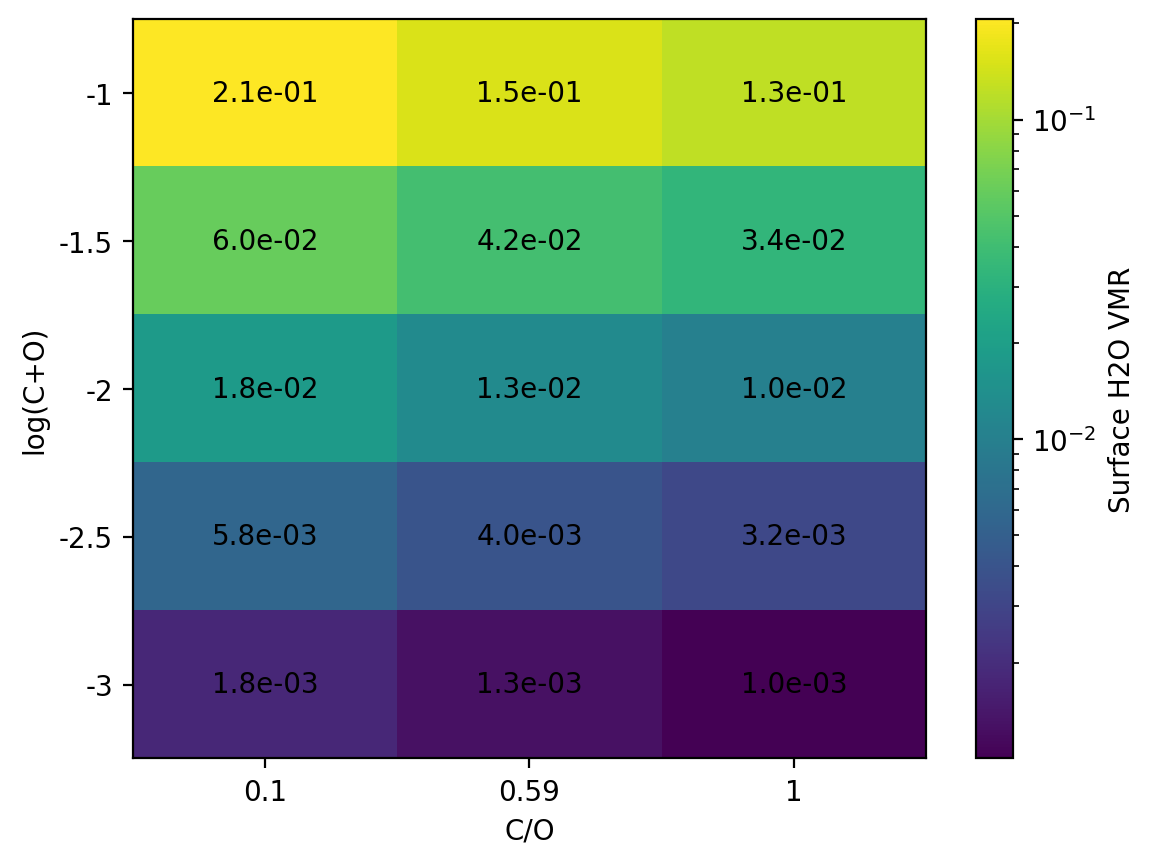

In [8]:
# To plot this, you first select/process the layer dimension
# For example, plot the surface abundance (layer = 0)
plot_matrix = data_matrix[:, :, 0]

fig, ax = plot_2d_matrix(
    plot_matrix,
    CtoOs,
    CplusOs,
    param1_name='C/O',
    param2_name='log(C+O)',
    z_label='Surface H2O VMR',
    log_z=True,
    display_text=True, # Display values in the cells
    text_fmt=".1e"
)
ax.set_yticklabels([f'{np.log10(v):.2g}' for v in CplusOs])
plt.show()

In [9]:
planet_r_dict = {
    'Earth': 6371e5  # cm
}


def get_total_liquid_water_mass(i_temp, i_press, combine=False, planet='Earth'):
    """
    Calculate the total mass of liquid water in the atmosphere.
    :param atmo_dict: dictionary containing the atmosphere data
    :param combine: if True, combine H2O and H2O[l]
    :return: total mass of liquid water in the atmosphere
    """
    h2o_mmw = 18.01528  # g/mol

    # get the mass of liquid water in each layer
    n_tots = load_parameter_matrix(
        folder,
        fixed_params=fixed_params,
        param1_name='CtoO',
        param1_values=CtoOs,
        param2_name='CplusO',
        param2_values=CplusOs,
        what_to_extract='n_tots'
    )
    
    h2o = load_parameter_matrix(
        folder,
        fixed_params=fixed_params,
        param1_name='CtoO',
        param1_values=CtoOs,
        param2_name='CplusO',
        param2_values=CplusOs,
        what_to_extract='H2O',
        mol_type='dust'
    )
    h2o *= n_tots * h2o_mmw * 1.66e-24 # mr -> cm^-3 -> g/cm^3
    
    h2o_l = load_parameter_matrix(
        folder,
        fixed_params=fixed_params,
        param1_name='CtoO',
        param1_values=CtoOs,
        param2_name='CplusO',
        param2_values=CplusOs,
        what_to_extract='H2O[l]',
        mol_type='dust'
    )
    h2o_l *= n_tots * h2o_mmw *1.66e-24 # mr -> cm^-3 -> g/cm^3

    # get altitude
    altitude = load_parameter_matrix(
        folder,
        fixed_params=fixed_params,
        param1_name='CtoO',
        param1_values=CtoOs,
        param2_name='CplusO',
        param2_values=CplusOs,
        what_to_extract='altitudes_cm'
    )
    
    if planet in planet_r_dict.keys():
        planet_r = planet_r_dict[planet]
        altitude = altitude + planet_r
    else:
        raise KeyError('Invalid planet name')

    # integrate over layers
    if combine:
        h2o = h2o + h2o_l
        h2o_l = np.zeros_like(h2o)

    # integrate over layers (4pi*rho*r^2)
    h2o_mass = 4 * np.pi * np.trapz(h2o * (altitude**2), x=altitude, axis=-1)
    h2o_l_mass = 4 * np.pi * np.trapz(h2o_l * (altitude**2), x=altitude, axis=-1)

    return h2o_mass, h2o_l_mass

earth_ocean = 1.4e24  # g

In [10]:
i_temp = 0
i_press = 2

data_matrix_h2o, data_matrix_h2o_l = get_total_liquid_water_mass(i_temp, i_press, combine=True, planet='Earth')
#data_matrix_h2o /= earth_ocean
#data_matrix_h2o_l /= earth_ocean
data_matrix_h2o /= 1e3  # convert to kg

title = r"$T_{int} = $" + f"{Tints[i_temp]} K, " + r"$P_{surf} = $" + f"{P0s[i_press]/1e6:g} bar"
plot_other(data_matrix_h2o, title, 'Water Mass [kg]', log=True, segmented=False, vmin=None, vmax=None, layer=0, display_text=True)

ValueError: operands could not be broadcast together with shapes (3,5,96) (3,5) 